# Mice classification based on protein expression

# Introduction
This data mining project aims to test out multiple classification techniques to find the most suitable ones for classifying mice into 8 categories based on the protein expression data. This is a high-dimensionality data clusterization exercise due to 77 proteins used as dimensions.

The analysis is implemented using Matplotlib, Pandas, Numpy, Scikit learn, Keras libraries in Python. The analysis is done in Google Colab Jupyter notebook using TensorFlow backend. 

Four models are used in this project: a basic dense neural network with SGD optimizer, a normalized dense neural network with Adam optimizer, K-nearest neighbors classifier and SVM classifier. 


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Using TensorFlow backend.


## Data overview

Data covers expression levels of 77 proteins measured in the cerebral cortex of 8 classes of control and Down syndrome (trisomic) mice exposed to context fear conditioning, a task used to assess associative learning. Data source is a Kaggle dataset (https://www.kaggle.com/ruslankl/mice-protein-expression). Following are the detailed 8 categories which are the training objective of the classification techniques in this project: 

1. c-CS-s: control mice, stimulated to learn, injected with saline (9 mice)
2. c-CS-m: control mice, stimulated to learn, injected with memantine (10 mice)
3. c-SC-s: control mice, not stimulated to learn, injected with saline (9 mice)
4. c-SC-m: control mice, not stimulated to learn, injected with memantine (10 mice)
5. t-CS-s: trisomy mice, stimulated to learn, injected with saline (7 mice)
6. t-CS-m: trisomy mice, stimulated to learn, injected with memantine (9 mice)
7. t-SC-s: trisomy mice, not stimulated to learn, injected with saline (9 mice)
8. t-SC-m: trisomy mice, not stimulated to learn, injected with memantine (9 mice)

In total this dataset covers 72 mice: 38 control mice and 34 trisomic mice (Down syndrome). According to the dataset description, in the experiments 15 measurements were registered of each protein per sample/mouse. In total for control mice  there are 38x15, or 570 measurements; and for trisomic mice there are 34x15, or 510 measurements. The dataset contains a total of 1080 measurements per protein. Each measurement can be considered as an independent sample/mouse. For the purposes of this project the data categories are considered balanced (7-10 mice for each category), thus accuracy measure is used to evaluate the chosen models. 

Data is imported as a CSV file. CSV file is read into a Pandas dataframe. Descriptive statistics is done with Pandas library. 

Since there are 77 proteins, this data set is a high-dimensionality dataset. Since I do not have information which dimensions are more or less relevant form the biological perspective, I am considering all dimensions relevant to classification. Thus I am interested to try using all the dimensions without dimension reduction first to evaluate the feasibility of such approach. So he methods, which support high dimensionality are prioritized. 

From the visual inspection of the protein histograms it is visible that some proteins are not normally distributed, so further in the analysis the non-parametric techniques are selected for classification. 

From the correlation matrix it is visible that there are strong positive correlations (some ranging to 1), and some negative less strong correlations between proteins. This is expected in high dimensionality data. For some classification techniques this could cause a problem and the topic will be addressed in further sections.



In [0]:
df = pd.read_csv('Data_Cortex_Nuclear.csv')

In [0]:
df.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,...,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,...,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,...,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,...,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,...,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.255528,0.140871,0.48

In [0]:
df.describe()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,RAPTOR_N,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
count,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1062.000000,1077.000000,1077.000000,1077.000000,1073.000000,1077.000000,1077.000000,1077.000000,1062.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,867.000000,795.000000,1080.000000,1005.000000,1080.000000,900.000000,870.000000,810.000000,1080.000000
mean,0.425810,0.617102,0.319088,2.297269,3.843934,0.233168,0.181846,3.537109,0.212574,1.428682,0.545904,0.313505,0.317939,0.275033,0.825813,0.726933,1.561965,1.525338,0.442848,0.682236,0.378519,0.363357,0.180492,1.173400,2.474492,1.172603,0.241644,0.272789,0.693180,0.168417,0.404808,2.146550,0.542635,0.452459,0.415311,0.759047,0.585186,0.368370,0.565317,0.357095,0.315813,0.418605,0.394475,0.181080,0.943116,0.161211,1.706599,0.292434,0.429226,1.197420,0.216482,0.166631,0.179307,0.121521,0.156478,0.181300,0.210489,0.120889,0.221851,0.126560,0.527349,0.291276,1.548348,2.235236,0.159821,1.239270,0.848767,0.226676,0.157914,0.134762,0.121521,0.131053,0.446073,0.169609,0.183135,0.205440,1.337784
std,0.249362,0.251640,0.049383,0.347293,0.933100,0.041634,0.027042,1.295169,0.032587,0.466904,0.345309,0.051978,0.052236,0.046164,0.117969,0.188013,0.270737,0.481780,0.066672,0.127434,0.216388,0.052352,0.026370,0.335786,0.653397,0.244752,0.033901,0.041075,0.120825,0.028138,0.061173,0.435742,0.280568,0.065488,0.089290,0.122446,0.100601,0.062583,0.088201,0.063025,0.054163,0.067288,0.156170,0.029296,0.172838,0.019308,0.578442,0.037380,0.137440,0.361743,0.185309,0.031896,0.018826,0.014276,0.015071,0.024919,0.069010,0.013233,0.034886,0.026885,0.082057,0.030015,0.248132,0.254395,0.024150,0.173580,0.094311,0.028989,0.029537,0.027417,0.014276,0.023863,0.066432,0.059402,0.040406,0.055514,0.317126
min,0.145327,0.245359,0.115181,1.330831,1.737540,0.063236,0.064043,1.343998,0.112812,0.429032,0.149155,0.052110,0.191431,0.056818,0.500160,0.281285,0.301609,0.567840,0.095942,0.064421,0.143894,0.212960,0.113636,0.497695,1.131796,0.151124,0.046298,0.147201,0.198743,0.107394,0.235595,1.134886,0.217120,0.201143,0.227880,0.166579,0.155321,0.226409,0.184785,0.185598,0.194824,0.237777,0.131120,0.117999,0.344120,0.099976,0.598767,0.181157,0.130206,0.529108,0.052528,-0.062008,0.072326,0.067254,0.100217,0.099734,0.096233,0.086114,0.111382,0.072580,0.284001,0.207438,0.853176,1.206098,0.101233,0.750664,0.577397,0.155869,0.088305,0.080657,0.067254,0.085419,0.258626,0.079691,0.105537,0.101787,0.586479
25%,0.288121,0.473361,0.287444,2.057411,3.155678,0.205755,0.164595,2.479834,0.190823,1.203665,0.337405,0.281242,0.281829,0.244287,0.743491,0.590303,1.381288,1.168258,0.404144,0.596816,0.264334,0.330859,0.161830,0.944435,1.991756,1.023134,0.220400,0.247096,0.617074,0.149622,0.366339,1.826707,0.319639,0.410389,0.351992,0.683501,0.530881,0.326621,0.514892,0.312766,0.276127,0.371976,0.281090,0.

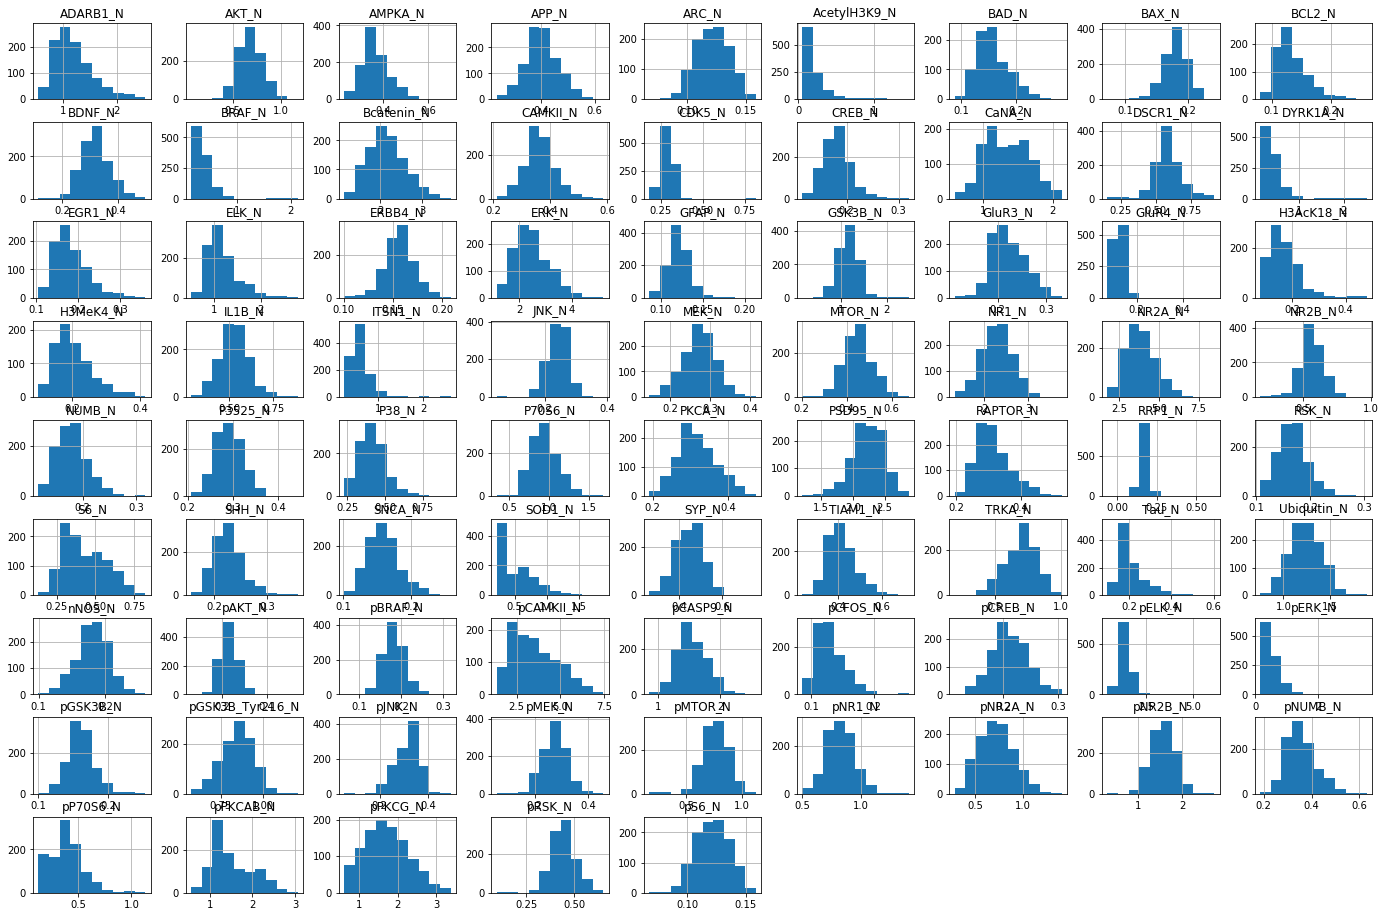

In [0]:
df.hist(figsize=(24,16));

In [0]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

# Data preparation

Since the observations from the same mouse are listed in sequence, the data is first shuffled using Scikit learn. The data is then split into equal sets for training and testing, each with 540 observations. 

The following data processing is done separately for train and test sets. 

## X values
X values are the 77 protein columns. They are placed into a new Pandas dataframe. NaN values are filled with 0. Pandas dataframe is converted into a Numpy array and rescaled into a range of values between 0 and 1. 

## Y values
Y values is the "class" column from the original dataset. 3 formats of the Y values are created for use in the different classification techniques: 


*   train_y_original and test_y_original - the original category names
*   train_y_int and test_y_int - categories encoded into integers from 0 to 7
*   train_y and test_y - categories encoded into one-hot encoding format





In [0]:
from sklearn.utils import shuffle
df_shuffled = shuffle(df, random_state=10)

In [0]:
df_shuffled.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
765,3502_1,0.281036,0.563611,0.376907,2.528481,4.990763,0.280896,0.202239,4.155913,0.252764,1.351575,0.313786,0.406018,0.349755,0.334220,0.911547,0.927922,1.851505,1.260462,0.495451,0.847586,0.274878,0.424773,0.198880,1.387544,2.775787,1.258782,0.290973,0.307208,0.852624,0.190903,0.425612,2.880196,0.835549,0.549895,0.510707,0.951015,0.623373,0.448006,0.681875,...,0.500210,0.442547,0.204157,1.052120,0.141947,1.684849,0.300736,0.383658,1.677946,0.190653,0.139595,0.173507,0.147864,0.168348,0.198240,0.199833,0.107048,0.201199,0.119794,0.487823,0.273120,1.522039,2.466960,0.156058,1.513315,0.738715,0.196950,NaN,0.109779,0.147864,0.094227,0.438434,0.162279,0.151202,NaN,0.944238,Ts65Dn,Memantine,S/C,t-SC-m
675,361_1,0.525160,0.786627,0.417844,2.947165,5.365686,0.215212,0.185214,3.710083,0.235920,1.515580,0.847397,0.350397,0.437875,0.273950,1.019450,1.017225,1.960712,2.586704,0.434198,0.760790,0.422973,0.355816,0.178440,1.807722,3.458099,1.529127,0.274531,0.328914,0.944552,0.167118,0.452487,2.715212,0.350010,0.472905,0.377105,0.786530,0.543449,0.434585,0.604800,...,0.407200,0.245113,0.219520,1.037173,0.168160,1.786347,0.323253,0.480213,2.121973,0.154613,0.156640,0.189973,0.111573,0.158347,0.187200,0.152213,0.118453,0.246613,0.127200,0.477440,0.302240,1.589813,2.362347,0.126880,1.167627,0.917493,0.221173,0.125920,0.101920,0.111573,0.107787,0.531040,0.110453,0.140267,0.134667,1.937760,Ts65Dn,Memantine,C/S,t-CS-m
109,3507_5,0.381520,0.580394,0.323729,2.405200,4.566981,0.216427,0.172545,2.151515,0.203179,1.377712,0.651101,0.322239,0.284153,0.236132,0.907932,0.628581,1.684716,1.239278,0.374897,0.685875,0.313959,0.348899,0.154993,1.180825,3.300215,1.203842,0.247226,0.237622,0.735055,0.150356,0.375393,2.279516,0.303361,0.433019,0.345256,0.751283,0.548932,0.330684,0.540652,...,0.360325,0.150025,0.199513,1.084651,0.157137,0.965024,0.295620,0.541768,1.180049,0.117194,0.153994,0.168187,0.121350,0.159063,0.212591,0.180049,0.126521,0.285077,0.149635,0.574513,0.279400,1.737024,2.403386,0.147810,1.166768,0.844891,0.224959,0.154197,NaN,0.121350,0.124493,0.487632,NaN,NaN,0.184813,1.558191,Control,Memantine,C/S,c-CS-m
539,3490_15,0.232640,0.423285,0.284615,2.175052,3.401663,0.265904,0.216632,2.773389,0.197089,1.188565,0.302495,0.293139,0.252391,0.275052,0.800624,0.598337,1.423493,1.133056,0.429522,0.815800,0.283576,0.393555,0.183784,1.032432,2.228482,0.973805,0.241996,0.269231,0.648857,0.176299,0.297297,1.944699,0.647609,0.387734,0.366736,0.684823,0.526403,0.306653,0.527235,...,0.315177,0.249688,0.157764,0.841134,0.153772,1.087693,0.284692,0.297770,0.835352,0.090171,0.156938,0.186949,0.126377,0.161481,0.180066,0.158315,0.112610,0.190804,0.090721,0.687362,0.271613,1.764317,2.267208,0.165061,1.286206,0.862885,0.262115,0.169741,0.154185,0.126377,0.177313,0.459802,0.183645,0.210077,0.267346,1.397302,Control,Saline,S/C,c-SC-s
485,3481_6,0.293697,0.501667,0.314812,2.774250,4.893951,0.232735,0.180346,3.228131,0.216701,1.180346,0.326401,0.335926,0.289411,0.269567,0.938562,0.925544,1.914431,1.240038,0.401969,0.798539,0.260200,0.362280,0.167646,1.312113,2.745991,1.124464,0.249563,0.269884,0.759168,0.154786,0.379584,2.752818,1.115733,0.486426,0.431338,0.806636,0.589935,0.353866,0.597873,...,0.392443,0.327195,0.192142,1.082885,0.146753,1.172856,0.292160,0.297363,1.472910,0.127915,0.158683,0.189541,0.136258,0.166398,0.214119,0.178418,0.120649,0.287496,0.174740

In [0]:
df_train = df_shuffled.head(540)

In [0]:
df_test = df_shuffled.tail(540)

In [0]:
#create a dataframe with all input data
train_X = df_train.drop(columns=['MouseID', 'Genotype', 'Treatment', 'Behavior', 'class'])
test_X = df_test.drop(columns=['MouseID', 'Genotype', 'Treatment', 'Behavior', 'class'])

train_X.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,RAPTOR_N,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
765,0.281036,0.563611,0.376907,2.528481,4.990763,0.280896,0.202239,4.155913,0.252764,1.351575,0.313786,0.406018,0.349755,0.334220,0.911547,0.927922,1.851505,1.260462,0.495451,0.847586,0.274878,0.424773,0.198880,1.387544,2.775787,1.258782,0.290973,0.307208,0.852624,0.190903,0.425612,2.880196,0.835549,0.549895,0.510707,0.951015,0.623373,0.448006,0.681875,0.390063,0.392022,0.500210,0.442547,0.204157,1.052120,0.141947,1.684849,0.300736,0.383658,1.677946,0.190653,0.139595,0.173507,0.147864,0.168348,0.198240,0.199833,0.107048,0.201199,0.119794,0.487823,0.273120,1.522039,2.466960,0.156058,1.513315,0.738715,0.196950,NaN,0.109779,0.147864,0.094227,0.438434,0.162279,0.151202,NaN,0.944238
675,0.525160,0.786627,0.417844,2.947165,5.365686,0.215212,0.185214,3.710083,0.235920,1.515580,0.847397,0.350397,0.437875,0.273950,1.019450,1.017225,1.960712,2.586704,0.434198,0.760790,0.422973,0.355816,0.178440,1.807722,3.458099,1.529127,0.274531,0.328914,0.944552,0.167118,0.452487,2.715212,0.350010,0.472905,0.377105,0.786530,0.543449,0.434585,0.604800,0.384169,0.293691,0.407200,0.245113,0.219520,1.037173,0.168160,1.786347,0.323253,0.480213,2.121973,0.154613,0.156640,0.189973,0.111573,0.158347,0.187200,0.152213,0.118453,0.246613,0.127200,0.477440,0.302240,1.589813,2.362347,0.126880,1.167627,0.917493,0.221173,0.125920,0.101920,0.111573,0.107787,0.531040,0.110453,0.140267,0.134667,1.937760
109,0.381520,0.580394,0.323729,2.405200,4.566981,0.216427,0.172545,2.151515,0.203179,1.377712,0.651101,0.322239,0.284153,0.236132,0.907932,0.628581,1.684716,1.239278,0.374897,0.685875,0.313959,0.348899,0.154993,1.180825,3.300215,1.203842,0.247226,0.237622,0.735055,0.150356,0.375393,2.279516,0.303361,0.433019,0.345256,0.751283,0.548932,0.330684,0.540652,0.387316,0.267760,0.360325,0.150025,0.199513,1.084651,0.157137,0.965024,0.295620,0.541768,1.180049,0.117194,0.153994,0.168187,0.121350,0.159063,0.212591,0.180049,0.126521,0.285077,0.149635,0.574513,0.279400,1.737024,2.403386,0.147810,1.166768,0.844891,0.224959,0.154197,NaN,0.121350,0.124493,0.487632,NaN,NaN,0.184813,1.558191
539,0.232640,0.423285,0.284615,2.175052,3.401663,0.265904,0.216632,2.773389,0.197089,1.188565,0.302495,0.293139,0.252391,0.275052,0.800624,0.598337,1.423493,1.133056,0.429522,0.815800,0.283576,0.393555,0.183784,1.032432,2.228482,0.973805,0.241996,0.269231,0.648857,0.176299,0.297297,1.944699,0.647609,0.387734,0.366736,0.684823,0.526403,0.306653,0.527235,0.253222,0.255094,0.315177,0.249688,0.157764,0.841134,0.153772,1.087693,0.284692,0.297770,0.835352,0.090171,0.156938,0.186949,0.126377,0.161481,0.180066,0.158315,0.112610,0.190804,0.090721,0.687362,0.271613,1.764317,2.267208,0.165061,1.286206,0.862885,0.262115,0.169741,0.154185,0.126377,0.177313,0.459802,0.183645,0.210077,0.267346,1.397302
485,0.293697,0.501667,0.314812,2.774250,4.893951,0.232735,0.180346,3.228131,0.216701,1.180346,0.326401,0.335926,0.289411,0.269567,0.938562,0.925544,1.914431,1.240038,0.401969,0.798539,0.260200,0.362280,0.167646,1.312113,2.745991,1.124464,0.249563,0.269884,0.759168,0.154786,0.379584,2.752818,1.115733,0.486426,0.431338,0.806636,0.589935,0.353866,0.597873,0.296237,0.297984,0.392443,0.327195,0.192142,1.082885,0.146753,1.172856,0.292160,0.297363,1.472910,0.127915,0.158683,0.189541,0.136258,0.166398,0.214119,0.178418,0.120649,0.287496,0.174740,0.594277,0.296645,1.800502,2.622264,0.164962,1.310639,0.863204,0.255292,0.151686,NaN,0.136258,0.122264,0

In [0]:
train_X.shape

(540, 77)

In [0]:
train_X.isnull().sum(axis = 0)

DYRK1A_N       2
ITSN1_N        2
BDNF_N         2
NR1_N          2
NR2A_N         2
            ... 
SYP_N          0
H3AcK18_N     83
EGR1_N       100
H3MeK4_N     126
CaNA_N         0
Length: 77, dtype: int64

In [0]:
test_X.isnull().sum(axis = 0)

DYRK1A_N       1
ITSN1_N        1
BDNF_N         1
NR1_N          1
NR2A_N         1
            ... 
SYP_N          0
H3AcK18_N     97
EGR1_N       110
H3MeK4_N     144
CaNA_N         0
Length: 77, dtype: int64

In [0]:
train_X.fillna(0, inplace=True)
test_X.fillna(0, inplace=True)

In [0]:
train_X.isnull().sum(axis = 0)

DYRK1A_N     0
ITSN1_N      0
BDNF_N       0
NR1_N        0
NR2A_N       0
            ..
SYP_N        0
H3AcK18_N    0
EGR1_N       0
H3MeK4_N     0
CaNA_N       0
Length: 77, dtype: int64

In [0]:
test_X.isnull().sum(axis = 0)

DYRK1A_N     0
ITSN1_N      0
BDNF_N       0
NR1_N        0
NR2A_N       0
            ..
SYP_N        0
H3AcK18_N    0
EGR1_N       0
H3MeK4_N     0
CaNA_N       0
Length: 77, dtype: int64

In [0]:
train_X.to_numpy()

array([[0.28103569, 0.56361092, 0.37690693, ..., 0.15120249, 0.        ,
        0.94423792],
       [0.52515967, 0.78662667, 0.41784401, ..., 0.14026667, 0.13466667,
        1.93776   ],
       [0.38152012, 0.5803941 , 0.32372909, ..., 0.        , 0.18481346,
        1.5581914 ],
       ...,
       [0.70260829, 0.69958081, 0.38775035, ..., 0.21508934, 0.23990735,
        1.1782484 ],
       [0.27094287, 0.4426919 , 0.29828251, ..., 0.21013865, 0.22140381,
        0.93078423],
       [0.51306914, 0.71268971, 0.3722597 , ..., 0.        , 0.23155505,
        1.34019783]])

In [0]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
train_X_norm = min_max_scaler.fit_transform(train_X.values)

In [0]:
train_X_norm

array([[0.11168309, 0.21844505, 0.75812019, ..., 0.44356046, 0.        ,
        0.24135667],
       [0.20869753, 0.30488179, 0.84046208, ..., 0.41147965, 0.357747  ,
        0.91162099],
       [0.15161543, 0.2249499 , 0.65115694, ..., 0.        , 0.49096382,
        0.6555509 ],
       ...,
       [0.27921531, 0.27114444, 0.77993093, ..., 0.63097591, 0.63732277,
        0.39922823],
       [0.10767222, 0.1715791 , 0.59997304, ..., 0.61645278, 0.58816744,
        0.23228035],
       [0.20389278, 0.27622521, 0.74877263, ..., 0.        , 0.61513458,
        0.50848491]])

In [0]:
test_X.to_numpy()

array([[0.34375   , 0.47040929, 0.3227323 , ..., 0.        , 0.        ,
        1.39200864],
       [0.16332454, 0.33245383, 0.25514512, ..., 0.20126815, 0.28062999,
        1.36244631],
       [0.29198537, 0.40571999, 0.29930163, ..., 0.25980486, 0.21790702,
        0.89879472],
       ...,
       [0.30090242, 0.42695996, 0.39509306, ..., 0.        , 0.27683616,
        0.68926554],
       [0.26890359, 0.47377127, 0.30340265, ..., 0.27727348, 0.        ,
        1.05892061],
       [0.36317793, 0.61332065, 0.40532826, ..., 0.18543113, 0.19571621,
        1.25597883]])

In [0]:
test_X_norm = min_max_scaler.fit_transform(test_X.values)

In [0]:
test_X_norm

array([[0.13859123, 0.18074159, 0.68658318, ..., 0.        , 0.        ,
        0.49755594],
       [0.06584829, 0.12773607, 0.54279769, ..., 0.55800543, 0.67800959,
        0.47742342],
       [0.11772105, 0.15588654, 0.63673659, ..., 0.72029539, 0.52646922,
        0.16166774],
       ...,
       [0.12131618, 0.1640474 , 0.84052403, ..., 0.        , 0.6688436 ,
        0.01897432],
       [0.10841507, 0.18203333, 0.64546113, ..., 0.76872622, 0.        ,
        0.27071656],
       [0.14642407, 0.23565127, 0.86229846, ..., 0.5140981 , 0.47285563,
        0.40491701]])

In [0]:
#create a dataframe with only the target column
train_y = df_train[['class']]
test_y = df_test[['class']]
test_y.head()

,class
72,c-CS-m
1063,t-SC-s
449,c-SC-s
215,c-SC-m
846,t-CS-s


In [0]:
train_y_original = df_train[['class']]
test_y_original = df_test[['class']]

In [0]:
train_y_original.shape

(540, 1)

In [0]:
train_y_int = train_y.replace(['c-CS-s', 'c-CS-m', 'c-SC-s', 'c-SC-m', 't-CS-s', 't-CS-m', 't-SC-s', 't-SC-m'], [0, 1, 2, 3, 4, 5, 6, 7])
test_y_int = test_y.replace(['c-CS-s', 'c-CS-m', 'c-SC-s', 'c-SC-m', 't-CS-s', 't-CS-m', 't-SC-s', 't-SC-m'], [0, 1, 2, 3, 4, 5, 6, 7])

In [0]:
n_classes = 8
train_y = keras.utils.to_categorical(train_y_int, n_classes)
test_y = keras.utils.to_categorical(test_y_int, n_classes)

# Method 1: Basic Dense Neural Network

This is a very basic dense neural network model to serve as a benchmark. The inputs for the network are 77 protein values for each mice observation. The values are rescaled into range from 0 to 1 and provided as train_X_norm and test_X_norm variables. For Y this model uses the one-hot encoded values from train_y and test_y variables.

The neural network consists of 2 dense layers (each neuron in the layer is connected to each of the neurons in the previous layer). Each layer has  1232 neurons with ReLU (Rectified Linear Units) activation functions (the shape of the ReLU function is defined by a = max(0, z)). ReLU is chosen as one of the most widely used activation functions, and because of how efficiently these neurons enable learning algorithms to perform computations (Basens et al, 2019). The last layer consists of 8 Softmax neurons to produce the probability of each observation allocation to each of the 8 mice classes. 

The model uses Stochastic gradient decent (SGD) optimizer with a learning rate of 0.1 (which is on a faster learning side than the default rate of 0.01). This is a basic optimizer but suitable for relatively shallow networks (such as 2 layers in this model case). 

The training in this case was allowed for 300 epochs without early stopping since no clear signs of overfitting were visible from performance of loss versus accuracy numbers in each epoch. The results show 98% accuracy for training data (80% split from 540 training observations), 95% accuracy for validation (20% split from 540 training observations). The predictions on remaining 540 test observations show 90% accuracy which in this specific iteration of calculations is the lowest from all four used models. 

In [0]:
import numpy as np
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD



In [0]:
#create model
model_1 = Sequential()

#add model layers
model_1.add(Dense(1232, activation='relu', input_shape=(77,)))
model_1.add(Dense(1232, activation='relu'))
model_1.add(Dense(8, activation='softmax'))

In [0]:
model_1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 1232)              96096     
_________________________________________________________________
dense_26 (Dense)             (None, 1232)              1519056   
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 9864      
Total params: 1,625,016
Trainable params: 1,625,016
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_1.compile(loss='mean_squared_error', optimizer=SGD(lr=0.1), metrics=['accuracy'])

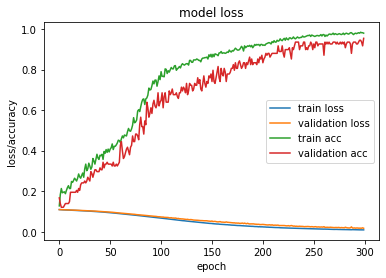

0.008960090691861869 0.016850770968529914 0.9791666622515078 0.9537036948733859


In [0]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3)
history_1 = model_1.fit(train_X_norm, train_y,
                batch_size=20,
                epochs=300,
                verbose=0, validation_split=0.2)

plt.figure()
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')
plt.legend(['train loss ', 'validation loss', 'train acc ', 'validation acc'])
plt.show()
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
acc = history_1.history['acc']
val_acc = history_1.history['val_acc']
print(loss[-1], val_loss[-1], acc[-1], val_acc[-1])

In [0]:
test_y_predictions_1 = model_1.predict(test_X_norm)

In [0]:
dataset = pd.DataFrame({'1': test_y_predictions_1[:, 0], '2': test_y_predictions_1[:, 1], '3': test_y_predictions_1[:, 2], '4': test_y_predictions_1[:, 3], '5': test_y_predictions_1[:, 4], '6': test_y_predictions_1[:, 5], '7': test_y_predictions_1[:, 6], '8': test_y_predictions_1[:, 7],})
dataset['predicted'] = dataset.idxmax(axis=1)
dataset.head()

,1,2,3,4,5,6,7,8,predicted
0,1.662148e-02,0.869719,0.092495,1.475560e-02,2.197450e-05,2.472817e-03,0.000042,0.003872,2
1,7.385391e-07,0.003511,0.027752,2.526729e-05,3.936548e-03,3.628130e-05,0.941520,0.023217,7
2,1.056531e-07,0.003329,0.968651,1.521098e-03,1.587419e-07,3.962032e-07,0.000350,0.026149,3
3,1.341534e-06,0.000126,0.000985,9.871435e-01,4.768183e-08,6.444283e-07,0.000122,0.011621,4
4,9.456664e-04,0.009110,0.000362,2.422711e-08,9.832367e-01,8.913322e-04,0.005314,0.000140,5


In [0]:
dataset_original = pd.DataFrame({'1': test_y[:, 0], '2': test_y[:, 1], '3': test_y[:, 2], '4': test_y[:, 3], '5': test_y[:, 4], '6': test_y[:, 5], '7': test_y[:, 6], '8': test_y[:, 7],})
dataset_original['category'] = dataset_original.idxmax(axis=1)
dataset_original.head()

,1,2,3,4,5,6,7,8,category
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5


In [0]:
correct = np.sum(dataset['predicted'] == dataset_original['category'])
accuracy = correct / (540 * 1.0)
print(accuracy)

0.8981481481481481


#Method 2: Normalized Dense Neural Network

This is a second neural network model based on Adam optimizer with additional normalization and regularization features to enable better learning. The inputs and outputs are the same as in the previous neural network.

The neural network consists of 2 dense layers, each with 1232 neurons with ReLU activation functions. The last layer consists of 8 Softmax neurons to produce the probability of each observation allocation to each of the 8 classes. 

Batch normalization layer is added after each dense layer. Batch normalization takes the activations output from the preceding layer, subtracts the batch mean, and divides by the batch standard deviation. This acts to recenter the distribution of the activation values with a mean of 0 and a standard deviation of 1. According to (Basens et al, 2019):
*   it allows layers to learn more independently from each other, because large values in one layer won’t excessively influence the calculations in the next layer
*   it allows for selection of a higher learning rate—because there are no extreme values in the normalized activations—thus enabling faster learning
* adds a noise element, especially with smaller batch sizes, which, contributes to regularization (helps a network generalize to data it hasn’t encountered previously)

Overfitting in this model is monitored through the verbose outputs of each training epoch. Overfitting is identified in the case when training cost continues to go down while validation cost goes up. Also the Dropout technique is applied to the last deep layer to prevent overfitting. It removes 20% of the layer’s neurons during each round of training. In this way, the model doesn’t become overreliant on certain features of the data to generate a good prediction (Basens et al, 2019).

In this model the SGD optimizer is replaced with the Adam (adaptive moment estimation) optimizer, which is a RMSProp (root mean square propagation) algorithm with two exceptions (Basens et al, 2019):

*   An extra moving average of past gradients is calculated for each parameter and used to inform the update instead of the actual gradients at that point.
*   A bias trick is used to help prevent moving averages from skewing toward zero at the start of training.

The training in this case was allowed for large number of epochs but early stopping monitoring was implemented to stop the training once the results are no longer improving. Training took a bit over 20 epochs to reach 100% accuracy for training data (80% split from 540 training observations), and 100% accuracy for validation data (20% split from 540 training observations). The predictions on remaining 540 test observations show 96% accuracy.

In [0]:
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
#create model
model_2 = Sequential()

#add model layers
model_2.add(Dense(1232, activation='relu', input_shape=(77,)))
model_2.add(BatchNormalization())
model_2.add(Dense(1232, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Dense(8, activation='softmax'))


In [0]:
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 1232)              96096     
_________________________________________________________________
batch_normalization_5 (Batch (None, 1232)              4928      
_________________________________________________________________
dense_29 (Dense)             (None, 1232)              1519056   
_________________________________________________________________
batch_normalization_6 (Batch (None, 1232)              4928      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1232)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 9864      
Total params: 1,634,872
Trainable params: 1,629,944
Non-trainable params: 4,928
_______________________________________

In [0]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

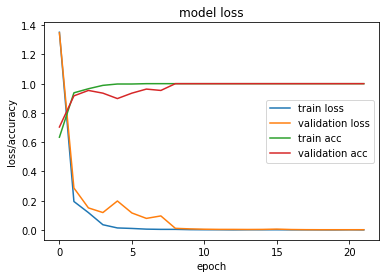

0.0007191736421427104 0.0019478199128234 1.0 1.0


In [0]:
early_stopping_monitor = EarlyStopping(patience=3)
history_2 = model_2.fit(train_X_norm, train_y,
                batch_size=50,
                epochs=600,
                verbose=0, validation_split=0.2, callbacks=[early_stopping_monitor])

plt.figure()
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')
plt.legend(['train loss ', 'validation loss', 'train acc ', 'validation acc'])
plt.show()
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
print(loss[-1], val_loss[-1], acc[-1], val_acc[-1])


In [0]:
test_y_predictions_2 = model_2.predict(test_X_norm)

In [0]:
dataset = pd.DataFrame({'1': test_y_predictions_2[:, 0], '2': test_y_predictions_2[:, 1], '3': test_y_predictions_2[:, 2], '4': test_y_predictions_2[:, 3], '5': test_y_predictions_2[:, 4], '6': test_y_predictions_2[:, 5], '7': test_y_predictions_2[:, 6], '8': test_y_predictions_2[:, 7],})
dataset['predicted'] = dataset.idxmax(axis=1)
dataset.head()

,1,2,3,4,5,6,7,8,predicted
0,1.277982e-06,9.999987e-01,4.219693e-08,1.803160e-09,1.529404e-11,5.258565e-10,1.292298e-12,2.578650e-08,2
1,7.285585e-14,4.047135e-06,2.896440e-06,2.991637e-09,6.268149e-07,1.641009e-12,9.999925e-01,1.103408e-09,7
2,4.258939e-09,1.455165e-03,9.985252e-01,5.015350e-08,8.803813e-11,7.745301e-13,1.242718e-07,1.954587e-05,3
3,1.277996e-09,6.636393e-11,1.843883e-07,9.999998e-01,5.440334e-10,4.030526e-13,5.535984e-11,1.427045e-08,4
4,2.966677e-11,2.315745e-07,4.541199e-11,6.762083e-15,9.999998e-01,5.838597e-10,5.881374e-09,1.542902e-10,5


In [0]:
dataset_original = pd.DataFrame({'1': test_y[:, 0], '2': test_y[:, 1], '3': test_y[:, 2], '4': test_y[:, 3], '5': test_y[:, 4], '6': test_y[:, 5], '7': test_y[:, 6], '8': test_y[:, 7],})
dataset_original['category'] = dataset_original.idxmax(axis=1)
dataset_original.head()

,1,2,3,4,5,6,7,8,category
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5


In [0]:
correct = np.sum(dataset['predicted'] == dataset_original['category'])
accuracy = correct / (540 * 1.0)
print(accuracy)

0.9629629629629629


#Method 3: K-nearest Neighbors Classifier

The K-nearest Neighbor (KNN) algorithm classifies based on distance to a selected number of training samples. The algorithm family is called instance-based learning as there are no parameters to learn. This model assumes that distance is sufficient for inference; otherwise it makes no assumptions about the underlying data or its distributions (thus, non-parametric) (Harrison, 2019)

The possible challenges in use of KNN are:

*   Selecting the right k value
*   Avoiding the curse of dimensionality in high dimensionality data case (Wikipedia contributors, 2019). 

According to Harrison (2019) the Scikit learn implementation in terms of calculation efficiency differs for training and testing, but both are linear. Training is O(1), but it needs to store the data. Testing is O(Nd) where N is the number of training examples and d is dimensionality. 

This algorithm performs better with standardized data, thus using the rescaled train_X_norm and test_X_norm variables. For Y using the one-hot encoded values.

Using 3 neighbors performs well and does not seem to be causing aforementioned problems related to high dimensionality. The distance type is Euclidean (set through default parameters p=2 and metric=’minkowski’ in KNeighborsClassifier()).

The model generalizes well from training data (score of 100%) to test data (score of 97%). The model performance is further tested by cross validation. Train data is additionally crossvalidated by k-fold splitting of data into 6 folds (cross_val_score() from Scikit learn used). The cross validation scores range from 99% to 98%, the estimated interval is 97% (+/- 2%).


In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [0]:
clf_1 = KNeighborsClassifier(3)
model_KNN = clf_1.fit(train_X_norm, train_y)
score1_KNN = clf_1.score(train_X_norm, train_y)
score2_KNN = clf_1.score(test_X_norm, test_y)
print(score1_KNN, score2_KNN)

1.0 0.9685185185185186


In [0]:
scores_KNN = cross_val_score(model_KNN, train_X_norm, train_y_original, cv=6)
print (scores_KNN)
print("Scores interval: %0.2f (+/- %0.2f)" % (scores_KNN.mean(), scores_KNN.std() * 2))

[0.97826087 0.97826087 0.95604396 0.97802198 0.96590909 0.98837209]
Scores interval: 0.97 (+/- 0.02)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when

#Method 4: Support Vector Machine

A traditional definition of Support Vector Machine (SVM) is used in this project according to Harrison (2019). This is an algorithm that tries to fit a hyperplane between the different classes that maximizes the distance from the plane to the points of the classes. In this way it tries to find a robust separation between the classes. The support vectors are the points of the edge of the dividing hyperplane. SVM is non-parametric since it does not rely on any underlying probabilistic model. 

SVC from Scikit learn which wraps the libsvm library is used in this project. This methods supports nonlinear spaces by using a kernel trick: it creates a decision boundary in a new dimension by minimizing a formula that is easier to calculate than actually mapping the points to the new dimension. The default Radial Basis Function ('rbf') kernel is used, which is controlled by the gamma parameter and can map an input space into a high dimensional space.

According to Harrison (2019) the scikit-learn implementation is O(n⁴) in terms of calculation efficiency, so it can be hard to scale to large sizes. However in this cases no noticeable issues were observed in application. 

This algorithm performs better with standardized data, thus using the rescaled train_X_norm and test_X_norm variables. For Y using the original categorical data train_y_original and test_y_original.

The C penalty parameter controls regularization. A smaller value allows for a smaller margin in the hyperplane - the tighter the decision boundary (more overfitting likely). A higher value for gamma can tend to overfit the training data. 

The model generalizes well from training data (score of 100%) to test data (score of 98%). The model performance is further tested by cross validation. Train data is additionally crossvalidated by k-fold splitting of data into 6 folds (cross_val_score() from Scikit learn used). The cross validation scores range from 100% to 99%, the estimated interval is 99% (+/- 1%).


In [0]:
from sklearn.svm import SVC
clf_2 = SVC(gamma=1, C=1)
model_SVC = clf_2.fit(train_X_norm, train_y_original)
score1_SVC = clf_2.score(train_X_norm, train_y_original)
score2_SVC = clf_2.score(test_X_norm, test_y_original)
print(score1_SVC, score2_SVC)

1.0 0.9833333333333333


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
scores_SVC = cross_val_score(model_SVC, train_X_norm, train_y_original, cv=6)
print (scores_SVC)
print("Scores interval: %0.2f (+/- %0.2f)" % (scores_SVC.mean(), scores_SVC.std() * 2))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[0.98913043 0.98913043 0.98901099 1.         1.         1.        ]
Scores interval: 0.99 (+/- 0.01)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Summary
This data mining project aimed to test out multiple classification techniques to find the most suitable one for classifying mice into 8 categories based on the protein expression data. The data has high-dimensionality due to 77 proteins used as dimensions.

Out of the four models used in this project - a basic dense neural network with SGD optimizer, a normalized dense neural network with Adam optimizer, K-nearest neighbors classifier and SVM classifier - all the models performed relatively weel, but a basic dense neural network accuracy was 2%-5% less than the other methods. However the statistical significance of this difference was not estimated, since this documentation covers just one run of calculations (fixed by seed functions for reproducibility).

The best training accuracy was achieved by the normalized dense neural network, KNN and the SVM classifier - all achieved 100% accuracy. The validation accuracy of 100% was achieved by the normalized dense neural network. Predictions on the 540 test observations were best in the KNN and the SVM classifier - 97% and 98%. But the prediction accuracy of the normalized dense neural network was also close - 96%.

The fact that simple model (for instance KNN with 3 neighbors) performance in this project is similar to those of neural networks (and even outperforms them in this particular run of calculations) could be an indication that simple patterns in protein data exist and they are sufficient to predict categories and that all 77 features are not needed. This could be part of the future research.

None of the models exhibited clear signs of overfitting based on the cross validation results, and additionally based on the performance of training cost versus validation cost estimates for the neural networks.

However it is important to note that all quantitative results described in this document are based on only one run of calculations, which uses random shuffling into 540 training and 540 testing sets as well as random split of validation subsets. These random effects introduce a possibility for variation, which does impact the results between calculation iterations. Further testing with multiple calculation iterations (with reshuffling) is needed to estimate the likely intervals for reliable accuracy prediction of different models.    

# References

Bassens, A., Krohn, J. and Beyleveld, G., "Deep Learning Illustrated: A Visual, Interactive Guide to Artificial Intelligence", Addison-Wesley Professional, 2019

Hand, D., Mannila, H., and Smyth, P., "Principles of Data Mining", The MIT Press, 2001

Harrison, M. "Machine Learning Pocket Reference", O'Reilly Media, Inc., 2019

Nielsen, M.A., "Neural Networks and Deep Learning", Determination Press, 2015

Wikipedia contributors, "Curse of dimensionality", Wikipedia, 2019, https://en.wikipedia.org/wiki/Curse_of_dimensionality

Zheng, A. Evaluating Machine Learning Models, O'Reilly Media, Inc., 2015

# Annex 1: Other tested methods
More classification methods were tested before selecting the ones described in the project. This section provides the remainig list which were tested, but dropped due to initial issues with training score or low generalization to test data. GaussianProcessClassifier() was training and generalizing well, but was dropped due to very slow performance.  

In [0]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=8)
clf.fit(train_X_norm, train_y)
score1 = clf.score(train_X_norm, train_y)
score2 = clf.score(test_X_norm, test_y)
print(score1, score2)

0.9907407407407407 0.7018518518518518


In [0]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
clf = RandomForestClassifier(max_depth=8, n_estimators=8, max_features=8)
clf.fit(train_X_norm, train_y)
score1 = clf.score(train_X_norm, train_y)
score2 = clf.score(test_X_norm, test_y)
print(score1, score2)

0.975925925925926 0.5314814814814814


In [0]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(alpha=1, max_iter=1000)
clf.fit(train_X_norm, train_y)
score1 = clf.score(train_X_norm, train_y)
score2 = clf.score(test_X_norm, test_y)
print(score1, score2)

0.9592592592592593 0.7351851851851852


In [0]:
clf = SVC(kernel="linear", C=0.025)
clf.fit(train_X_norm, train_y_original)
score1 = clf.score(train_X_norm, train_y_original)
score2 = clf.score(test_X_norm, test_y_original)
print(score1, score2)

0.37037037037037035 0.32222222222222224


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
clf = GaussianProcessClassifier(1.0 * RBF(1.0)) #very slow :)
model = clf.fit(train_X_norm, train_y_original)
score1 = clf.score(train_X_norm, train_y_original)
score2 = clf.score(test_X_norm, test_y_original)
print(score1, score2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0 0.9259259259259259


In [0]:
scores = cross_val_score(model, train_X_norm, train_y_original, cv=6)
print (scores)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[0.9893617  1.         0.97777778 1.         0.97752809 1.        ]


In [0]:
clf = AdaBoostClassifier()
clf.fit(train_X_norm, train_y_original)
score1 = clf.score(train_X_norm, train_y_original)
score2 = clf.score(test_X_norm, test_y_original)
print(score1, score2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.30185185185185187 0.2740740740740741


In [0]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(train_X_norm, train_y_original)
score1 = clf.score(train_X_norm, train_y_original)
score2 = clf.score(test_X_norm, test_y_original)
print(score1, score2)

0.8185185185185185 0.7351851851851852


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis()
clf.fit(train_X_norm, train_y_original)
score1 = clf.score(train_X_norm, train_y_original)
score2 = clf.score(test_X_norm, test_y_original)
print(score1, score2)

1.0 0.24259259259259258


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [0]:
clf = LinearDiscriminantAnalysis()
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = clf.fit(train_X_norm, train_y_original)
score1 = clf.score(train_X_norm, train_y_original)
score2 = clf.score(test_X_norm, test_y_original)
print(score1, score2)

0.9962962962962963 0.6907407407407408


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
